<a href="https://colab.research.google.com/github/Vinuthnadivi/medical-project/blob/main/DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense


In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/adil200/Medical-Diagnoser/main/medical_data.csv')
data.head()


,Patient_Problem,Disease,Prescription
0,"Constant fatigue and muscle weakness, struggli...",Chronic Fatigue Syndrome,"Cognitive behavioral therapy, graded exercise ..."
1,"Frequent severe migraines, sensitivity to ligh...",Migraine with Aura,"Prescription triptans, avoid triggers like bri..."
2,"Sudden weight gain and feeling cold, especiall...",Hypothyroidism,Levothyroxine to regulate thyroid hormone levels.
3,"High fever, sore throat, and swollen lymph nod...",Mononucleosis,"Rest and hydration, ibuprofen for pain."
4,"Excessive thirst and frequent urination, dry m...",Diabetes Mellitus,Insulin therapy and lifestyle changes.


In [ ]:
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(data['Patient_Problem'])

sequences = tokenizer.texts_to_sequences(data['Patient_Problem'])
max_length = max(len(x) for x in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
# Encoding the labels
label_encoder_disease = LabelEncoder()
label_encoder_prescription = LabelEncoder()

disease_labels = label_encoder_disease.fit_transform(data['Disease'])
prescription_labels = label_encoder_prescription.fit_transform(data['Prescription'])

# Converting labels to categorical
disease_labels_categorical = to_categorical(disease_labels)
prescription_labels_categorical = to_categorical(prescription_labels)
Y = np.hstack((disease_labels_categorical, prescription_labels_categorical))


In [ ]:
input_layer = Input(shape=(max_length,))

embedding = Embedding(input_dim=5000, output_dim=64)(input_layer)
lstm_layer = LSTM(64)(embedding)

disease_output = Dense(len(label_encoder_disease.classes_), activation='softmax',
name='disease_output')(lstm_layer)

prescription_output = Dense(len(label_encoder_prescription.classes_),
activation='softmax', name='prescription_output')(lstm_layer)


In [ ]:
model = Model(inputs=input_layer, outputs=[disease_output, prescription_output])

model.compile(
    loss={'disease_output': 'categorical_crossentropy',
    'prescription_output': 'categorical_crossentropy'},
    optimizer='adam',
    metrics={'disease_output': ['accuracy'], 'prescription_output': ['accuracy']}
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 17, 64)    │    320,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     33,024 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ disease_output      │ (None, 178)       │     11,570 │ lstm[0][0]        │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prescription_output │ (None, 388)       │     25,220 │ lstm[0][0]        │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 389,814 (1.49 MB)

 Trainable params: 389,814 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(padded_sequences, {'disease_output': disease_labels_categorical, 'prescription_output':
      prescription_labels_categorical}, epochs=100, batch_size=32)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - disease_output_accuracy: 0.7286 - disease_output_loss: 1.2569 - loss: 3.3697 - prescription_output_accuracy: 0.5951 - prescription_output_loss: 2.1119
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - disease_output_accuracy: 0.7614 - disease_output_loss: 1.2261 - loss: 3.3868 - prescription_output_accuracy: 0.6070 - prescription_output_loss: 2.1619
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - disease_output_accuracy: 0.7441 - disease_output_loss: 1.2478 - loss: 3.3962 - prescription_output_accuracy: 0.5699 - prescription_output_loss: 2.1494
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - disease_output_accuracy: 0.7373 - disease_output_loss: 1.2479 - loss: 3.3607 - prescription_output_accuracy: 0.6043 - prescription_output_loss: 2.1123
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - disease_output_accuracy: 0.7635 - disease_output_loss: 1.1940 - loss: 3.2917 - prescription_output_accuracy: 0.5939 - prescrip

In [ ]:
def make_prediction(patient_problem):
    # Preprocessing the input
    sequence = tokenizer.texts_to_sequences([patient_problem])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')

    # Making prediction
    prediction = model.predict(padded_sequence)

    # Decoding the prediction
    disease_index = np.argmax(prediction[0], axis=1)[0]
    prescription_index = np.argmax(prediction[1], axis=1)[0]

    disease_predicted = label_encoder_disease.inverse_transform([disease_index])[0]
    prescription_predicted = label_encoder_prescription.inverse_transform([prescription_index])[0]

    print(f"Predicted Disease: {disease_predicted}")
    print(f"Suggested Prescription: {prescription_predicted}")


patient_input = "I've experienced a loss of appetite and don't enjoy food anymore."
make_prediction(patient_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Disease: Depression
Suggested Prescription: Antidepressants; eating nutrient-rich foods.


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Predict on the same data (since no X_test/Y_test split is shown)
predictions = model.predict(padded_sequences)

# Decode true labels (from one-hot to integers)
y_true_disease = np.argmax(disease_labels_categorical, axis=1)
y_true_prescription = np.argmax(prescription_labels_categorical, axis=1)

# Decode predicted labels
y_pred_disease = np.argmax(predictions[0], axis=1)
y_pred_prescription = np.argmax(predictions[1], axis=1)

# Accuracy Scores
acc_disease = accuracy_score(y_true_disease, y_pred_disease)
acc_prescription = accuracy_score(y_true_prescription, y_pred_prescription)

print(f"Disease Prediction Accuracy: {acc_disease:.4f}")
print(f"Prescription Prediction Accuracy: {acc_prescription:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Disease Prediction Accuracy: 0.9386
Prescription Prediction Accuracy: 0.8280


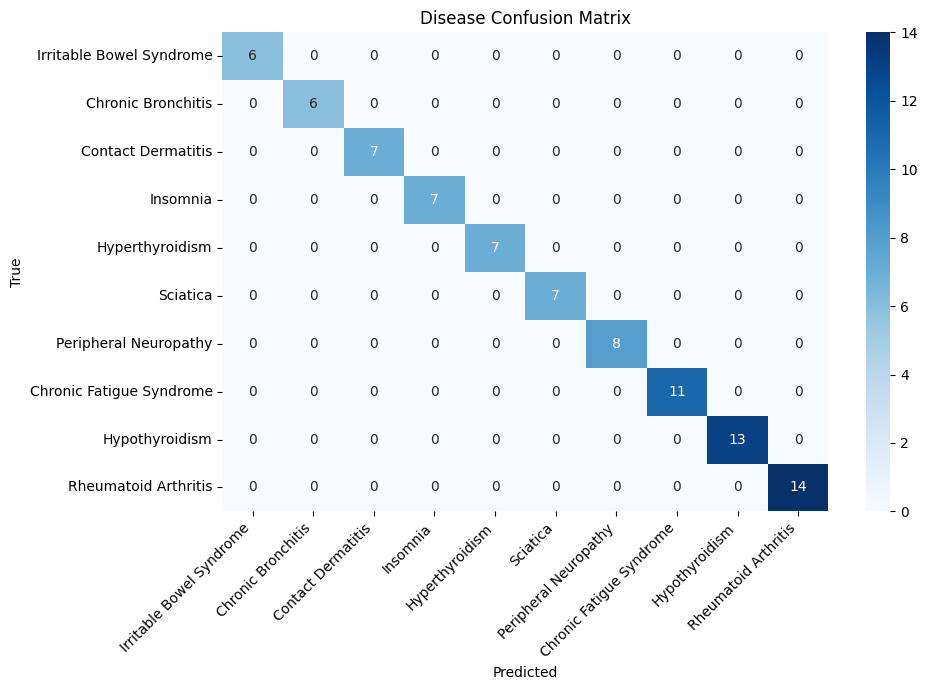

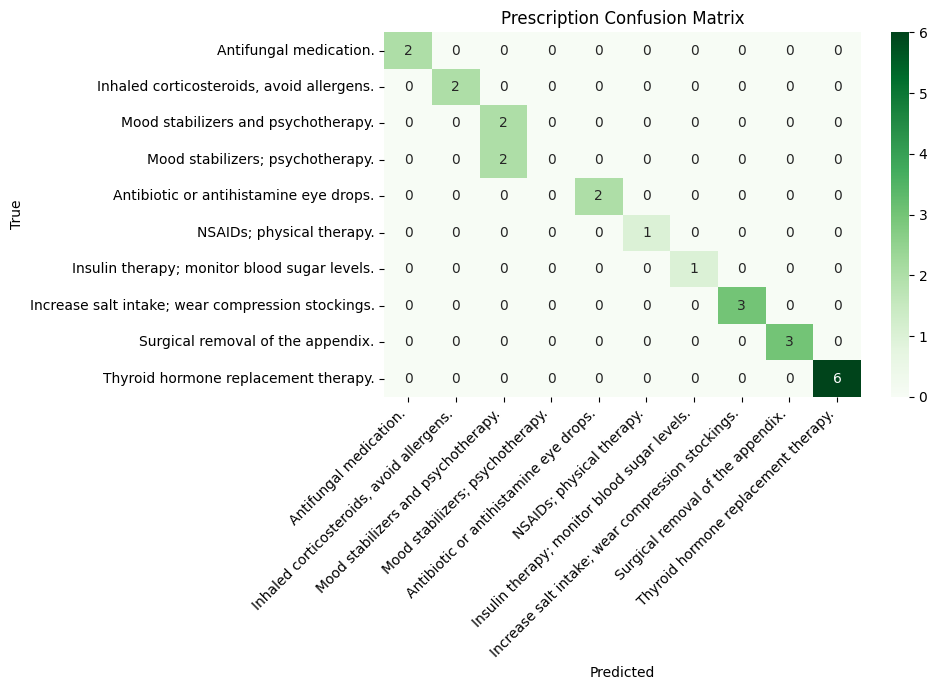

In [ ]:
import seaborn as sns
import pandas as pd

# Get label names
disease_names = label_encoder_disease.classes_
prescription_names = label_encoder_prescription.classes_

# Create confusion matrices
cm_disease = confusion_matrix(y_true_disease, y_pred_disease)
cm_prescription = confusion_matrix(y_true_prescription, y_pred_prescription)

# Function to show top N classes (optional)
def plot_confusion_matrix(cm, labels, title, top_n=10, cmap='Blues'):
    # Find most frequent classes
    most_common = np.argsort(np.sum(cm, axis=1))[-top_n:]
    cm_reduced = cm[np.ix_(most_common, most_common)]
    labels_reduced = [labels[i] for i in most_common]

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_reduced, annot=True, fmt='d', cmap=cmap,
                xticklabels=labels_reduced, yticklabels=labels_reduced)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot with reduced labels
plot_confusion_matrix(cm_disease, disease_names, "Disease Confusion Matrix", top_n=10)
plot_confusion_matrix(cm_prescription, prescription_names, "Prescription Confusion Matrix", top_n=10, cmap='Greens')


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Accuracy
disease_acc = accuracy_score(y_true_disease, y_pred_disease)
prescription_acc = accuracy_score(y_true_prescription, y_pred_prescription)

# Precision, Recall, F1 (macro avg handles class imbalance)
disease_precision = precision_score(y_true_disease, y_pred_disease, average='macro')
disease_recall = recall_score(y_true_disease, y_pred_disease, average='macro')
disease_f1 = f1_score(y_true_disease, y_pred_disease, average='macro')

prescription_precision = precision_score(y_true_prescription, y_pred_prescription, average='macro')
prescription_recall = recall_score(y_true_prescription, y_pred_prescription, average='macro')
prescription_f1 = f1_score(y_true_prescription, y_pred_prescription, average='macro')

# Print
print("\n✅ Overall Evaluation Metrics:")
print(f"Disease Accuracy      : {disease_acc:.4f}")
print(f"Disease Precision     : {disease_precision:.4f}")
print(f"Disease Recall        : {disease_recall:.4f}")
print(f"Disease F1 Score      : {disease_f1:.4f}")

print(f"\nPrescription Accuracy : {prescription_acc:.4f}")
print(f"Prescription Precision: {prescription_precision:.4f}")
print(f"Prescription Recall   : {prescription_recall:.4f}")
print(f"Prescription F1 Score : {prescription_f1:.4f}")



✅ Overall Evaluation Metrics:
Disease Accuracy      : 0.9386
Disease Precision     : 0.9062
Disease Recall        : 0.9141
Disease F1 Score      : 0.9013

Prescription Accuracy : 0.8280
Prescription Precision: 0.7812
Prescription Recall   : 0.8247
Prescription F1 Score : 0.7936


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
